In [1]:
from bs4 import BeautifulSoup

import pandas as pd
import os

In [2]:
confirmed_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
confDF = pd.read_csv(confirmed_URL)

# global_path = os.path.join(os.getcwd(), 'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_confirmed_global.csv')
global_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
globalDF = pd.read_csv(global_URL)

# death_path = os.path.join(os.getcwd(), 'csse_covid_19_data', 'csse_covid_19_time_series', 'time_series_covid19_deaths_US.csv')
deathsUS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
deathDF = pd.read_csv(deathsUS_URL)

deathsGlobal_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deathGlobalDF = pd.read_csv(deathsGlobal_URL)
# dateDict = dict(zip(confDF.columns[11:], pd.to_datetime(confDF.columns[11:])))
# confDF = confDF.rename(dateDict, axis='columns')

popPath = os.path.join(os.getcwd(), 'USpopulation.csv')
popDF = pd.read_csv(popPath)

In [3]:
byStateDF = confDF.groupby('Province_State').sum()

states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming']

byStateDF = byStateDF.loc[states]

deathStateDF = deathDF.groupby('Province_State').sum()

deathStateDF = deathStateDF.loc[states]

# population = confDF.set_index('Combined_Key').join(popDF[['NAME', 'POP']].set_index('NAME'))['POP']




In [4]:

# joining on FIPS code

popDF['FIPS'] = popDF['FIPS'].astype(float)
confDF['FIPS'] = confDF['FIPS'].astype(float)
confDF = confDF.set_index('FIPS').join(popDF[['FIPS', 'POP']].set_index('FIPS'))

confDF = confDF[~confDF.index.isnull()]
confDF = confDF[~confDF.POP.isnull()]


# rearranging columns so population is not at the end
columns = confDF.columns.tolist()

first = columns[:10]
first.append(columns[-1])

columns = first + columns[10:-1]

confDF = confDF[columns]

In [5]:
# find trailing average and divide by population

rate = (confDF.iloc[:,15:].diff(axis=1).rolling(window=7, axis=1).mean().iloc[:,-1] / confDF['POP']).tolist()

FIPS = [i.zfill(5) for i in confDF.index.astype(int).astype(str)]

FIPS = ['FIPS_' + num for num in FIPS]

data = pd.Series(data=rate,index=FIPS)


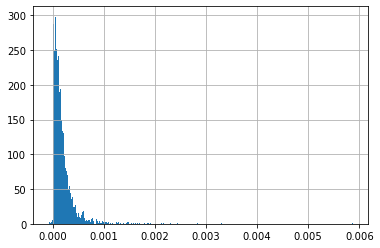

In [6]:
# check color coding intervals

hist = data.hist(bins=300)

In [7]:
# Load the SVG map
svg = open('counties.svg', 'r').read()
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

# Map colors
colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]
 
# County style
path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1; stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt; marker-start:none;stroke-linejoin:bevel;fill:'

In [8]:
# Color the counties based on unemployment rate
for p in paths:
     
    if p['id'] not in ["State_Lines", "separator"]:
        # pass
        try:
            rate = data[data.index == p['id']].item()
        except:
            continue

        # print(rate) 
        if rate > 0.001:
            color_class = 5
        elif rate > 0.0008:
            color_class = 4
        elif rate > 0.0006:
            color_class = 3
        elif rate > 0.0004:
            color_class = 2
        elif rate > 0.0002:
            color_class = 1
        else:
            color_class = 0
 
        color = colors[color_class]
        p['style'] = path_style + color

# Output map
COVIDmap = soup.prettify()

with open('map.svg', 'w') as file:
    file.write(COVIDmap)


In [9]:
# https://electionlab.mit.edu/data

electionPath = os.path.join(os.getcwd(), 'countypres_2000-2016.csv')
electionDF = pd.read_csv(electionPath)



In [10]:
only2016 = electionDF[electionDF['year'] == 2016]

FIPScodes = only2016.FIPS.unique().tolist()

In [11]:
electionFIPS = pd.Series(dtype=str)

for code in FIPScodes:
    try:
        temp = only2016[only2016['FIPS'] == code]
        # print(code)
        temp = temp[temp['candidatevotes'] == temp['candidatevotes'].max()]
        # print(temp)
        electionFIPS = electionFIPS.append(pd.Series(data=temp['party'].item(), index=[('FIPS_' + temp['FIPS'].astype(int).astype(str).item().zfill(5))], dtype=str))
    except:
        print(code)


51515.0
nan


In [12]:
data = pd.DataFrame(data)
electionFIPS = pd.DataFrame(electionFIPS)

data = pd.merge(data, electionFIPS, left_index=True, right_index=True)

In [19]:
columns = ['rate', 'voting']

data = data.rename(columns=dict(zip(data.columns, columns)))

In [33]:
# Load the SVG map
svg = open('counties.svg', 'r').read()
soup = BeautifulSoup(svg, selfClosingTags=['defs','sodipodi:namedview'])
paths = soup.findAll('path')

# Map colors
blueColors = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
redColors = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15']

 
# County style
path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1; stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt; marker-start:none;stroke-linejoin:bevel;fill:'

In [34]:
# Color the counties based on new infections per capita
for p in paths:
     
    if p['id'] not in ["State_Lines", "separator"]:
        # pass
        try:
            rate = data[data.index == p['id']].rate.item()
        except:
            continue

        # print(rate) 
        if rate > 0.001:
            color_class = 5
        elif rate > 0.0008:
            color_class = 4
        elif rate > 0.0006:
            color_class = 3
        elif rate > 0.0004:
            color_class = 2
        elif rate > 0.0002:
            color_class = 1
        else:
            color_class = 0
 
        if data[data.index == p['id']].voting.item() == 'democrat':
            color = blueColors[color_class]
        if data[data.index == p['id']].voting.item() == 'republican':
            color = redColors[color_class]
        p['style'] = path_style + color

# Output map
COVIDmap = soup.prettify()

with open('mapByParty.svg', 'w') as file:
    file.write(COVIDmap)
